In [1]:
import numpy as np
import sisl as si
from sisl.viz import merge_plots
from sisl.viz.processors.math import normalize
import matplotlib.pyplot as plt

%matplotlib inline

# Electronic structure calculation -- a walk-through

This tutorial will describe a complete walk-through of a large fraction of the `sisl` functionalities. It will show you how to generated default geometries, constructing Hamiltonians, calculating eigenstates and plotting various physical quantities.

## Creating the geometry to investigate

Our system of interest will be graphene. Instead of creating a graphene flake, or the primary unit-cell of graphene, we will create a vacancy in graphene.
We will start by creating a graphene flake

In [2]:
graphene = si.geom.graphene().tile(6, 0).tile(6, 1)

This does *a lot* of things behind the scenes:

1. `si.geom.graphene`:
    - create atomic coordinates of pristine graphene with a default bond-length of $1.42\,\mathrm{Å}$.
    - create pristine graphene unit cell, by default this will create a supercell
    with a size `3x3`, i.e. a nearest neighbour unit-cell.
    - assign a carbon atom with a default of one orbital per atom as the basis
2. `Geometry.tile` tiles the geometry `(reps, axis)` by `reps` times along the unit cell axis `axis`

By printing the object one gets basic information regarding the geometry, such as 1) number and species of atoms, 2) number of orbitals, 3) orbitals associated with each atom and 4) number of supercells.

In [3]:
print(graphene)

Geometry{na: 72, no: 72,
 Atoms{species: 1,
  Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
   Orbital{R: 1.43420, q0: 0.0}
  }: 72,
 },
 maxR: 1.43420,
 Lattice{nsc: [3 3 1],
  origin=[0.0000, 0.0000, 0.0000],
  A=[12.7800, -7.3785, 0.0000],
  B=[12.7800, 7.3785, 0.0000],
  C=[0.0000, 0.0000, 20.0000],
  bc=[Periodic,
      Periodic,
      Unknown]
 }
}


In this example we have `na=72` atoms, each have one orbital, hence the total number of orbitals is `no=72`. The description of the atomic specie in the geometry tells us we have a carbon atom, with a single orbital with a radius of $1.4342\,\mathrm{Å}$. The number of supercells are `[3, 3, 1]` which means cells `{-1, 0, 1}` along the first and second lattice are taken into account.

Later we will look into the details of *orbitals* associated with *atoms* and how they may be used for wavefunctions etc.

Lets visualize the atomic positions (here adding atomic indices)

In [4]:
graphene.plot(axes="xy")

Removing an atom can be done with `Geometry.remove`. The routine takes an index, or a list of indices of the atoms to be removed. For instance removing the first atom will result in the following geometry (red atom is the removed atom)

In [5]:
coord = graphene.sub(0)
coord.plot(axes="xy", atoms_style={"color": "red"}).merge(
    graphene.remove(0).plot(axes="xy")
)

INFO	Task(Task-2) nodify.node.140129860684688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897854064:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860483120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129863174528:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860692032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897854064:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860483120:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129863174528:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860692032:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860480192:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862970560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860481776:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860693232:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860484944:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860692848:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860692272:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860691840:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860682768:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860691648:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860691360:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860482448:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860691024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860483504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860683536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860690928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860690736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129898024976:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860483888:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860690640:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479808:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129898251808:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858775296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858770592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129863497632:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129900284720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860484560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860480192:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862970560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860686224:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129863174768:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860682768:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897843936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860687520:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860683920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897843888:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860480336:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860683152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862959664:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860688144:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129898024976:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860481008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860481392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860220736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860688816:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860695056:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860682000:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860694864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860682384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860683920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860690784:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479808:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129863497632:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129900284720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860484560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860480192:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862970560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860686224:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129863174768:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860682768:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897843936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860687520:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860683920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897843888:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860684304:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897853584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860480192:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862970560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860479472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860688000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860695872:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860682768:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860694912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860690112:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860696016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129863496576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860819696:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860828432:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860815040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860828240:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860828048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860828432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860815040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860828240:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860828048:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697456:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860820992:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860814320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858765120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860816624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858764928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860828288:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860827856:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860817776:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860827664:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860827376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860814752:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860827040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860815520:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860818544:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826944:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826752:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860825456:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860815856:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697984:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858953504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897530912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859197008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860822048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860821856:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860816240:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697456:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860820992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860821280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860821568:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860817776:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860822000:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860823104:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860818928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860823392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860813168:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860818160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860824400:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860823824:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860825456:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860813600:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860813840:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860825696:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860824544:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858766992:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860817008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858766800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860817392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860818928:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860826800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697984:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860822048:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860821856:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860816240:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697456:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860820992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860821280:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860821568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860817776:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860822000:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823104:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860818928:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823392:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860819312:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697456:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860820992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860824592:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697552:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860823680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862403760:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860817776:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860826704:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858768768:node.py:get()- Evaluated because inputs changed.


For the following it doesn't matter which atom we remove (since it is peridiodic), however for visualization purposes we will remove an atom in the middle of the unit cell.

Using `sisl` it is easy to find atoms close to specific positions. The middle of the atomic coordinates is also the *center* of atomic coordinates, here `Geometry.center` is useful. The complementary method `Geometry.close` finds all atomic indices close to a given position or atom. By default, `Geometry.close` determines all atoms within a radius equal to the maximum orbital radius. Here we explicitly set the *search radius* to $1.5\,\mathrm{Å}$.

In [6]:
xyz_center = graphene.center(what="xyz")
indices = graphene.close(xyz_center, 1.5)
index = indices[0]
system = graphene.remove(index)
graphene.plot(
    axes="xy",
    atoms_style=[
        {"opacity": 0.5},  # Default style for all atoms
        {
            "atoms": indices,
            "color": "black",
            "size": 1.2,
            "opacity": 1,
        },  # Styling for indices_close_to_center on top of defaults.
        {
            "atoms": index,
            "color": "red",
            "size": 1,
            "opacity": 1,
        },  # Styling for center_atom_index on top of defaults.
    ],
)

INFO	Task(Task-2) nodify.node.140129859376848:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860697072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859194176:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859386784:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859078576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860697072:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859194176:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859386784:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859078576:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468224:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859377088:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859202096:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859669264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859201328:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859678144:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897855024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859676080:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859077376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859674736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859677664:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859203344:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859672720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859194032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859671664:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859672384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859676704:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859193600:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858775152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859465152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859383376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857814496:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857812192:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858953504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897904032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859200800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468224:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859377088:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859375264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858947696:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859077376:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859562112:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859466880:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859385392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859201616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468128:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859382416:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859081264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859090528:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859676704:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859458864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859467360:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859676944:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859673824:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859674640:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859199408:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859678576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859091008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859385392:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859672576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859465152:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858953504:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129897904032:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859200800:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468224:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859377088:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859375264:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858947696:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859077376:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859562112:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859466880:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859385392:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859201616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859377520:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859463616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468224:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859377088:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859552560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859468560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859678720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859077376:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859561632:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129897855264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859678864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859675072:node.py:get()- Evaluated because inputs changed.


## Creating the electronic structure

To calculate eigenstates, DOS and other physical quantities from the Hamiltonian we need to setup the Hamiltonian.  Tthis is done by passing a `Geometry` to a `Hamiltonian` class

In [7]:
H = si.Hamiltonian(system)
print(H)

Hamiltonian{non-zero: 0, orthogonal: True,
 Spin{unpolarized},
 Geometry{na: 71, no: 71,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
    Orbital{R: 1.43420, q0: 0.0}
   }: 71,
  },
  maxR: 1.43420,
  Lattice{nsc: [3 3 1],
   origin=[0.0000, 0.0000, 0.0000],
   A=[12.7800, -7.3785, 0.0000],
   B=[12.7800, 7.3785, 0.0000],
   C=[0.0000, 0.0000, 20.0000],
   bc=[Periodic,
       Periodic,
       Unknown]
  }
 }
}


In addition to the `Geometry` information it informs us that it is an orthogonal basis (`sisl` also allows non-orthogonal basis'). The spin-configuration is an unpolarized configuration (see `Spin` for details).  
Currently `non-zero = 0` specifies that there are *no* associated Hamiltonian elements stored in this Hamiltonian object.

`Hamiltonian.construct` lets one specify the Hamiltonian elements in a consistent way. However, note that the `Hamiltonian` objet may be used as though it was a matrix, i.e. `Hamiltonian[0, 1] = a` will set the hopping element from the 0th orbital to the 1st orbital to `a`.  
We will specify all on-site elements to $0.\,\mathrm{eV}$, and all nearest neighbour interactions with $-2.7\,\mathrm{eV}$, this is the most common used graphene tight-binding model.  
The arguments for the `construct` method is a list of radii and an accompanying list of energies. Here `r` tells `sisl` to find all atoms within a sphere of $0.1\,\mathrm{Å}$ from each atom and set the corresponding element to $0$, secondly all atoms within a spherical radius of $0.1\,\mathrm{Å}$ to $1.44\,\mathrm{Å}$ are given the matrix element $-2.7\,\mathrm{eV}$

In [8]:
r = (0.1, 1.44)
t = (0.0, -2.7)
H.construct([r, t])
print(H)

Hamiltonian{non-zero: 281, orthogonal: True,
 Spin{unpolarized},
 Geometry{na: 71, no: 71,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
    Orbital{R: 1.43420, q0: 0.0}
   }: 71,
  },
  maxR: 1.43420,
  Lattice{nsc: [3 3 1],
   origin=[0.0000, 0.0000, 0.0000],
   A=[12.7800, -7.3785, 0.0000],
   B=[12.7800, 7.3785, 0.0000],
   C=[0.0000, 0.0000, 20.0000],
   bc=[Periodic,
       Periodic,
       Unknown]
  }
 }
}


Now the Hamiltonian has $281=71\cdot4-3$ non-zero elements (as expected).

## Hamiltonian eigenstates

At this point we have 1) a complete geometry describing a supercell structure with nearest cell neighbour interactions, 2) a Hamiltonian with nearest neighbour interactions describing the electronic structure.  
This completes what is needed to calculate a great deal of physical quantities, e.g. eigenstates, density of states, projected density of states and bandstructures.

To begin with we calculate the $\Gamma$-point eigenstates and plot a subset of the eigenstates' norm on the geometry.

In [9]:
es = H.eigenstate()
# Reduce the contained eigenstates to only 3 states around the Fermi-level
es_fermi = es.sub(range(len(H) // 2 - 1, len(H) // 2 + 2))

plots = [
    system.plot(axes="xy", atoms_style=[{"size": n * 20, "color": c}])
    for n, c in zip(es_fermi.norm2(projection="orbital"), ("red", "blue", "green"))
]

merge_plots(*plots, composite_method="subplots", cols=3)

INFO	Task(Task-2) nodify.node.140129857886048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857942640:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858083568:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859091872:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859373488:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857942640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858083568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859091872:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859373488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857936688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857883312:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858088896:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858091104:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858083376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857798704:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857933136:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857942688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857800672:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858183360:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858176160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858089712:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858176928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858091008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857805760:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858181296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858175248:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857941680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858175296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858082656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858090720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857812384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857935584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857887152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858090576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857936688:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857883312:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857931216:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857881632:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857800672:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857801440:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857882880:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857802256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932464:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858088800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857798752:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857813152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859667056:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857941680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858092592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858083232:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858175584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857812576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181728:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086880:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858187392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858085296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857802256:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858175152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858082656:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857880864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857887152:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858090576:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857936688:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857883312:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857931216:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857881632:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857800672:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857801440:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857882880:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857802256:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857932464:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857886096:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859372912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857936688:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857883312:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858181488:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857932992:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129859671040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858180816:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857800672:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858087072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859378624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858181968:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857931600:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858190944:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858412688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858180384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858412496:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858412304:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858412688:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858180384:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858412496:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858412304:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858087504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858405296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858184128:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858413696:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858182928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858413504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858412544:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858412112:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858189024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858411920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858411632:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858184512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858411296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858184704:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858189792:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858411200:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858411008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409712:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858182592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858410912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857812432:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857807152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857798800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858565856:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858406304:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858406016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858186624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858087504:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858405872:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858189024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858406256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407360:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858190176:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407648:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858180288:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858189408:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858408656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858408080:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409712:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858182736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858185616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409952:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858408800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858415568:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858188544:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858415376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858188784:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858190176:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858411056:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857812432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858406304:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858406016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858186624:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858087504:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405872:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858189024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858406256:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407360:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858190176:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407648:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858190560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857880288:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858087504:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858405296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858086016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858416384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858189024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858415424:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858410576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858416528:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858417392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858490576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858499312:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858420368:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858499120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858498928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858499312:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858420368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858499120:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858498928:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858491872:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858419504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858500320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858487504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858500128:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858499168:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858498736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858488656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858498544:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858498256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858420032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858486352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858489424:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497824:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497632:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858496336:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858486736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858418016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859379488:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858091680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859385056:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858492928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858492736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858487120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858491872:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858492448:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858488656:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492880:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858493984:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858489808:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858494272:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858418352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858489040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858495280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858494704:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858496336:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858418880:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858419216:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858496576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858495424:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858502192:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858487888:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858502000:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858488272:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858489808:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858497680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858418016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492928:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492736:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858487120:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858491872:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492160:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492448:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858488656:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858492880:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858493984:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858489808:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494272:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858490192:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858407024:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858408512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858491872:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858495472:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858409568:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858494560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858552224:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858488656:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129858502048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497200:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858497440:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129858553136:node.py:get()- Evaluated because inputs changed.


The `Hamiltonian.eigenstate` (with an optional $k$-point argument) routine returns an `EigenstateElectron` object which holds the eigenvalues and eigenvectors for a given $k$-point. This object can perform several advanced calculations:

- `EigenstateElectron.DOS`: calculate the DOS at a given set of energy values (in eV), additionally one can pass a distribution function if the default Gaussian with $\sigma=0.1\,\mathrm{eV}$ is not wanted.
- `EigenstateElectron.PDOS`: calculate the projected DOS at a given set of energy values (in eV), additionally one can pass a distribution function if the default Gaussian with $\sigma=0.1\,\mathrm{eV}$ is not wanted.
- `EigenstateElectron.wavefunction`: add *all* contained eigenstates to a passed real-space grid.

Lets first try and calculate the DOS for a given set of energies in the range $-4\,\mathrm{eV}$ : $\mathrm{4}\,\mathrm{eV}$

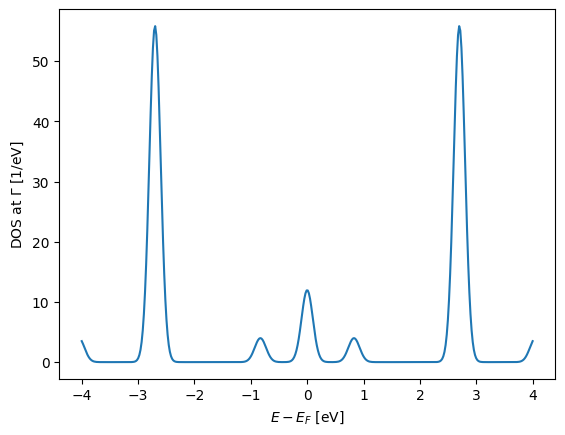

In [10]:
E = np.linspace(-4, 4, 400)
plt.plot(E, es.DOS(E))
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]");

The projected DOS (in this case) can aptly be plotted on individual atoms as will be seen in the following. We will integrate the PDOS in the range $-1\,\mathrm{eV}$ to $-0.5\,\mathrm{eV}$

In [11]:
E = np.linspace(-1, -0.5, 100)
dE = E[1] - E[0]
PDOS = es.PDOS(E).sum((0, 2)) * dE  # perform integration
system.plot(axes="xy", atoms_style={"size": normalize(PDOS, 0, 1)})
# plt.scatter(system.xyz[:, 0], system.xyz[:, 1], 500 * PDOS);
# plt.scatter(xyz_remove[0], xyz_remove[1], c='k', marker='*'); # mark the removed atom

INFO	Task(Task-2) nodify.node.140129821101568:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822586208:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822100128:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822784928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129857931696:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822586208:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822100128:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822784928:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129857931696:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822027616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822787344:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822105120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822102576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859381792:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822573536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129820755344:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860826224:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821099648:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822786576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822800304:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822098256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859555008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822799968:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821100416:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821106176:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821105984:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822799392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822788352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821105888:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030064:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821268288:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821277792:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821262240:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822783008:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822029536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822790656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822027616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822787344:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821102960:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129860821280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821099648:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822787152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822100080:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821100800:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822099072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129859092400:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821100032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822029296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822783392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822799392:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822097488:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822100752:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820756352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822799296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821109536:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129820754096:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822798720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821098640:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821100800:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821106032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030064:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822783008:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822029536:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822790656:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822027616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822787344:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821102960:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129860821280:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821099648:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822787152:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822100080:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821100800:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822099072:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821101184:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129862591040:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822027616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822787344:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822028096:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822030640:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821103296:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822029152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821099648:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822876032:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822028480:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129820756016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822786912:node.py:get()- Evaluated because inputs changed.


This highlights a somewhat *localized* state around the missing atom.

## Brillouin-zone calculations

The above DOS and PDOS analysis are useful for investigating a single $k$-point at a time. However, they are incomplete in the sense of the full Brillouin zone. To leverage this `sisl`, implements several classes to handle Brillouin-zones.

In the following we will show how to perform band structure calculations as well as performing $k$-averaged quantities in the Brillouin zone.

### Bandstructure

An easy and useful analysis is the *band structure*. In `sisl` calculating the band-structure is as easy as anything else.  
Begin by defining the path in the Brillouin zone.

In [12]:
band = si.BandStructure(
    H,
    [[0, 0, 0], [0, 0.5, 0], [1 / 3, 2 / 3, 0], [0, 0, 0]],
    200,
    [r"Gamma", r"M", r"K", r"Gamma"],
)

Note that the integer `400` determines the total number of $k$-points on the full band. One *can* define an explicit number between the different points, however we highly encourage only specifying *one* integer as the divisions will be determined based on the length in the reciprocal space between the points and thus the physical distance in the Brillouin zone will be correct.

A word of note on the `BrillouinZone` objects.

The `BrillouinZone` objects are *extremely* handy because they allow to directly call *any* routine inherent to the passed object. If calling routine `band.a()` it is equivalent to:

    for k in band: yield band.parent.a(k=k)
    
Note that `BrillouinZone` defaults to use `BrillouinZone.apply.iter`.
    
However, for large systems this may result in memory problems in which case it may be necessary to return an iterator. To circumvent this we can tell the Brillouin zone object to (always) return a list instead:

    b_list = band.apply.list
    as_list = b_list.a()
        
Another option is to return $k$-point averaged quantities which is roughly equivalent to (internally it is done with minimal memory usage):

    band.apply.average.a() == sum([band.parent.a(k=k) * band.weight[i] for i, k in enumerate(band)])

Now we can calculate the band structure. A band-structure requires *all* eigenvalues and thus we ask the `BrillouinZone` object to return all values using `apply.array`.

In [13]:
band.plot(Erange=[-3, 3])

INFO	Task(Task-2) nodify.node.140130118560144:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821439424:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118562208:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821430016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821439616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821429584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821434912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821429152:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821428096:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821265504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118552608:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821429296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821437936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118563936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118551744:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821437936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821388592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426224:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821262048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118563072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821437936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821886512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118552608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821379088:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821439424:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118562208:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822105264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821439424:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118562208:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821430016:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821439616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821429584:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821434912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821429152:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118551648:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822796320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118555440:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118555920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118554480:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118561824:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821437936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129822799200:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129822575648:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821392240:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821429536:node.py:get()- Evaluated because inputs changed.


### Calculating $k$-averaged quantities

Now we are in a position to calculate a subset of quantities from the Hamiltonian. Before proceeding we will note that the Hamiltonian also implements the `DOS` and `PDOS` methods (equivalent to `Hamiltonian.eigenvalue().DOS()`), hence to calculate these as $k$-averaged quantities we can create a Brillouin zone object with proper weights, say a Monkhorst-Pack grid, and calculate the averaged quantities.

In [14]:
bz = si.MonkhorstPack(H, [15, 15, 1])
bz_average = (
    bz.apply.average
);  # specify the Brillouin zone to perform an average of subsequent method calls

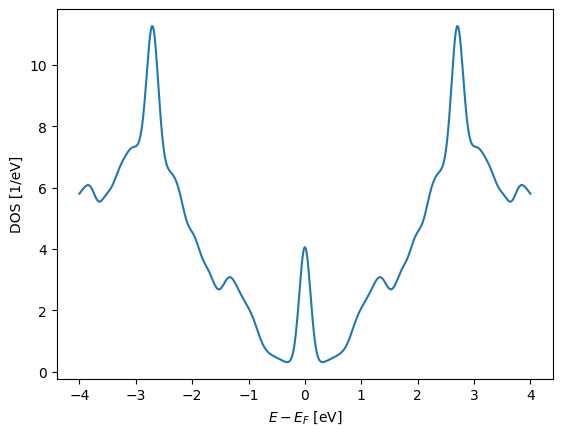

In [15]:
E = np.linspace(-4, 4, 1000)
plt.plot(E, bz_average.eigenstate(wrap=lambda es: es.DOS(E)))
plt.xlabel("$E - E_F$ [eV]")
plt.ylabel("DOS [1/eV]");

We can also plot the projected DOS integrated around the Fermi level on the atoms

In [16]:
E = np.linspace(-1, 1, 1000)
dE = E[1] - E[0]
PDOS = bz_average.eigenstate(wrap=lambda es: es.PDOS(E).sum((0, 2))) * dE

In [17]:
system.plot(axes="xy", atoms_style={"size": normalize(PDOS, 0, 1)})

INFO	Task(Task-2) nodify.node.140130119541360:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119008864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119259280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119011936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119256496:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119008864:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119259280:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119011936:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119256496:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426560:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119534352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119135072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119374304:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119372048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119011264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821275296:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119010016:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119537232:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119378048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392336:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119256736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821434624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119381024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119540256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119544624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119259760:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119370608:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119373584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119260768:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119012368:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821439904:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119374592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118579936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118551984:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119010160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119380352:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119534352:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119015248:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119381504:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119537232:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119257312:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821387392:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119537712:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821428912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119014384:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119537136:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119008768:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118580320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119370608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119016160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119131808:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119008672:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119382512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119546400:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119373824:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119544000:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119533872:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119537712:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550928:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119012368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118551984:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119010160:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119380352:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119534352:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119015248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119381504:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119537232:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119257312:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821387392:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119537712:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821428912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119540496:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821438368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426560:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119534352:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129820755248:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821426368:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140129821392720:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118578736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119537232:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118579072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118553616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821386912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119371184:node.py:get()- Evaluated because inputs changed.


## Plotting eigenstates on a real space grid

`sisl` also implements methods to plot orbitals on grids. Often it may also be advantageous to plot simple orbitals to check their appearence. `sisl` implements a simple variation of spherical atomic orbitals. Other orbitals may easily be added, if so desired.

Since we require orbitals to be zero at some maximum cut-off $r_\mathrm{max}$ a radial function is used to cutoff the spherical harmonics. In this case we will simply use an exponential function with a cutoff radius of $1.6\,\mathrm{Å}$

Normalization: 1.0053998295349618


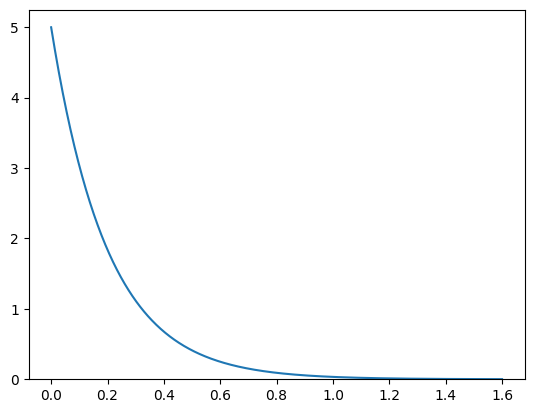

In [18]:
r = np.linspace(0, 1.6, 700)
f = 5 * np.exp(-r * 5)
print("Normalization: {}".format(f.sum() * (r[1] - r[0])))
plt.plot(r, f)
plt.ylim([0, None])
orb = si.SphericalOrbital(1, (r, f));

To calculate the orbital on a 3D grid, the `Orbital.toGrid` function is available. Here we create an orbital with azimuthal quantum number $l=1$ and by default it has angular moment $0$, i.e. the $2p_z$ orbital. To create a $2p_x$ or $2p_y$ orbital requires the use of an `AtomicOrbital` to denote the $m$ quantum number. Below we create the grid that describes the $p_z$ orbital and plot the $yz$ plane at $x=0$ (with respect to the position of the orbital).

Note that the real-space orbital will *not* be normalized and thus $\int|\psi(\mathbf r)|^2\neq 1$, as it should. The following analysis is thus a qualitative analysis.

In [19]:
grid = orb.toGrid()
index = grid.index(-grid.origin)

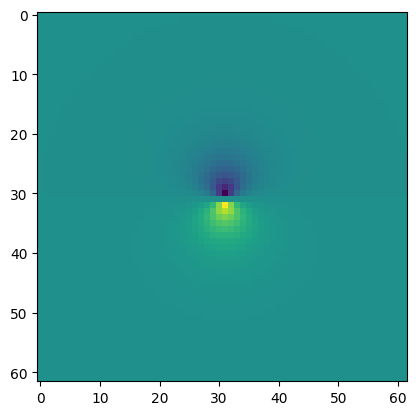

In [20]:
plt.imshow(grid.grid[index[0], :, :].T);

This *simple orbital model* may be used to plot the real-space tight-binding eigenstates. Our first task will be to tell the geometry that the orbital associated with the Carbon atoms is the $2p_z$ orbital as noted above. First we create the Carbon atom, then we replace the atom in the system geometry.

In [21]:
C = si.Atom(6, orb)
print(system.atoms)
system.atoms.replace(system.atoms[0], C)
print(system.atoms)

Atoms{species: 1,
 Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
  Orbital{R: 1.43420, q0: 0.0}
 }: 71,
}
Atoms{species: 1,
 Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.55180,
  SphericalOrbital{l: 1, R: 1.5517999999999998, q0: 0.0}
 }: 71,
}


Note the difference between the two `print(system)` statements, before the replacement, an intrinsic `Orbital` object describes the orbital, in effect no knowledge other than the radius. After replacement, the spherical orbital with azimuthal angular moment $l=1$ is replaced. Now we can plot the real-space grid for an eigenstate.

Lets plot one of the $\Gamma$-point eigenstates close to the Fermi-level.

In [22]:
es = H.eigenstate(dtype=np.float64).sub([len(H) // 2 + 1])
grid = si.Grid(0.075, lattice=H.lattice)
es.wavefunction(grid)

In [23]:
index = grid.index([0, 0, 0.1])
grid = grid.sub(index, 2)

In [24]:
grid.plot(axes="xy")

INFO	Task(Task-2) nodify.node.140130327332912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328828608:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328962848:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329244256:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327246512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118564512:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327238400:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328831680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327243680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119532768:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329244784:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327333488:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327334688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329037520:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327248576:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328828608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328962848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329244256:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327246512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118564512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327238400:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328831680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119136608:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328462736:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119372912:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119382272:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328828608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328962848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329244256:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327246512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118564512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327238400:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328831680:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119136608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327246512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328832064:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119259184:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329036896:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329239120:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329241280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119259664:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329041840:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328828608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329240176:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242624:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327245936:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327334592:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328828608:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327332048:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328965920:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329242912:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327246512:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327333920:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329047072:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129900415600:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327245744:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328349008:node.py:get()- Evaluated because inputs changed.


Note that the plot function will automatically orthogonalize by extending the grid.
To see the grid plot in the lattice vector representation one can do the following. However, this will introduce a skewedness in the plot that should be quite visible.  
The above plot shows $\psi(x, y, 0.1\,\mathrm{Å})$ for all $x$ and $y$. Note the similarity with the norm of the Hamiltonian eigenstates. However, in this plot we see that the wavefunction changes sign on alternating atoms.

In [25]:
grid.plot(axes="ab")

INFO	Task(Task-2) nodify.node.140130328358656:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327233264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327238784:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119378432:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329234848:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119384432:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329240752:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119370464:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327243968:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119377712:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119535024:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140129821265456:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328359760:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119377952:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329243248:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327233264:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327238784:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119378432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329234848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119384432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329240752:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119370464:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241376:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119382416:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329247184:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119379104:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327233264:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327238784:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119378432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329234848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119384432:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329240752:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119370464:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130327241376:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329234848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119381264:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329232448:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329245456:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329246320:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329236192:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130329233744:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119377856:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327233264:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329235472:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130119538864:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119377040:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328356688:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327233264:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328348960:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130327241616:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130118550832:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130329234848:node.py:get()- No need to evaluate


INFO	Task(Task-2) nodify.node.140130328355104:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118559280:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130118549584:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130119373680:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-2) nodify.node.140130328829424:node.py:get()- Evaluated because inputs changed.
